In [41]:
import os
import sys
import math
import rich
import torch
import random
import numpy  as np
import pandas as pd
import seaborn  as sns
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm 
from dotenv   import load_dotenv
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.contingency_tables import mcnemar

In [2]:
# Load DATA_PATH from .env file
load_dotenv()
data_path  = os.getenv("DATA_PATH")
model_path = os.getenv("MODEL_PATH")
cebab_path = os.getenv("CEBAB_PATH")

In [3]:
if cebab_path not in sys.path:
    sys.path.append(cebab_path)

from sparse_model import SubnetLinear_Mask, insert_sparse_mask, set_sparse_index, setup_seed

In [21]:
class MyDataset(Dataset):
    # Split = train/dev/test
    def __init__(self, dataframe, skip_class = "no majority"):
        self.data = dataframe
        self.labels = self.data["predicted_sentiment"].values
        self.text = self.data["text"].values
        self.map_dict = {"Negative":0, "Positive":1, "unknown":2, "":2,"no majority":2}
        
        # the 28 concepts
        self.concepts = ['admiration', 'amusement', 'anger', 'annoyance', 
                    'approval', 'caring', 'confusion', 'curiosity', 'desire', 
                    'disappointment', 'disapproval', 'disgust', 'embarrassment', 
                    'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 
                    'nervousness', 'optimism', 'pride', 'realization', 'relief',
                    'remorse', 'sadness', 'surprise', 'neutral']
        for c in self.concepts:
            setattr(self, f"{c}_aspect", self.data[c].values)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.labels[idx] - 1
        
        # gold labels
        for c in self.concepts:
            setattr(self, f"{c}_concept", self.data[c].map(self.map_dict).values)

        concept_labels = []
        tensor_dict = {}
        
        for concept in self.concepts:
            concept_value = getattr(self, f"{concept}_concept")[idx]
            concept_labels.append(concept_value)
            tensor_dict[f"{concept}_concept"] = torch.tensor(concept_value, dtype=torch.long)
        
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )
        
        return {
                "input_ids": encoding["input_ids"].flatten(),
                "attention_mask": encoding["attention_mask"].flatten(),
                "label": torch.tensor(label, dtype=torch.long),
                "concept_labels": torch.tensor(concept_labels, dtype=torch.long),
                **tensor_dict
            }

In [6]:
max_len = 512
batch_size = 8
lambda_XtoC = 5.
is_aux_logits = False
num_labels = 5
num_each_concept_classes = 3

In [7]:
data = os.path.join(data_path, "goemo_samples_1000.csv")
data = pd.read_csv(data)
num_concept_labels = 28
train_df, temp_df = train_test_split(data, test_size=0.2, random_state=42)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=42) 

# Load the data
train_dataset = MyDataset(train_df)
test_dataset = MyDataset(test_df)
val_dataset = MyDataset(val_df)

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [8]:
concepts = ['admiration', 'amusement', 'anger', 'annoyance', 
            'approval', 'caring', 'confusion', 'curiosity', 'desire', 
            'disappointment', 'disapproval', 'disgust', 'embarrassment', 
            'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 
            'nervousness', 'optimism', 'pride', 'realization', 'relief',
            'remorse', 'sadness', 'surprise', 'neutral']

## Model w. sparsity 0.5-0.7

In [14]:
# Load the model and tokenizer
model = os.path.join(model_path, "distilbert-base-uncased_mcnemar0.50.7_joint.pth")
model = torch.load(model, map_location=torch.device('cpu'))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): SubnetLinear_Mask(
            (fc): Linear(in_features=768, out_features=768, bias=True)
            (mask_list): ParameterList(
                (0): Parameter containing: [torch.float32 of size 768x768]
                (1): Parameter containing: [torch.float32 of size 768x768]
                (2): Parameter containing: [torch.float32 of size 768x768]
                (3): Parameter containing: [torch.float32 of size 768x768]
                (4): Parameter containing: [torch.float32 of size 768x768]
                (5

In [15]:
ModelXtoCtoY_layer = torch.load(model_path+"/distilbert-base-uncased_mcnemar0.50.7_ModelXtoCtoY_layer_joint.pth",
                                map_location=torch.device('cpu')) 
num_epochs = 1

In [24]:
# Initialize accumulators
test_accuracy = 0.
concept_test_accuracy = 0.
predicted_labels = np.array([])
true_labels = np.array([])
concept_predicted_labels = np.array([])
concept_true_labels = np.array([])

# Initialize a list to store activated concepts
activated_concepts_test = []

# List to store predictions for y_pred_modelA
y_pred_modelA = []

# Counter for examples displayed
examples_displayed = 0
max_examples = 5

# Evaluate the model
for epoch in range(num_epochs):
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Test", unit="batch")):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label = batch["label"].to(device)
            concept_tensors = {}
            for concept in concepts:
                concept_key = f"{concept}_concept"
                if concept_key in batch:
                    concept_tensors[concept] = batch[concept_key].to(device)  
            concept_labels = batch["concept_labels"].to(device)
            concept_labels = torch.t(concept_labels)
            concept_labels = concept_labels.contiguous().view(-1)

            XtoC_outputs = []
            XtoY_outputs = []
            for concept_idx in range(num_concept_labels):
                set_sparse_index(model, concept_idx)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                pooled_output = outputs.last_hidden_state.mean(1)

                outputs = ModelXtoCtoY_layer(pooled_output)
                XtoC_outputs.append(outputs[concept_idx + 1])
                XtoY_outputs.extend(outputs[0:1])

            # Predict labels
            predictions = torch.argmax(XtoY_outputs[0], axis=1)
            test_accuracy += torch.sum(predictions == label).item()
            predicted_labels = np.append(predicted_labels, predictions.cpu().numpy())
            true_labels = np.append(true_labels, label.cpu().numpy())
            
            # Store the predictions for this model 
            y_pred_modelA.extend(predictions.cpu().numpy())

            # Predict concepts
            XtoC_logits = torch.cat(XtoC_outputs, dim=0)
            concept_predictions = torch.argmax(XtoC_logits, axis=1)
            concept_predictions = concept_predictions.view(-1, num_concept_labels)
            concept_labels = concept_labels.view(-1, num_concept_labels)

            # Store predicted concepts for each batch
            batch_predicted_concepts = torch.argmax(torch.cat(XtoC_outputs, dim=0), dim=1)
            activated_concepts_test.extend(batch_predicted_concepts.cpu().numpy())
            batch_true_concepts = torch.argmax(concept_labels, axis=1)

            # Print some example texts with their labels and concepts
            if examples_displayed < max_examples:
                for i in range(len(label)):
                    print("Text:", tokenizer.decode(input_ids[i], skip_special_tokens=True))
                    print("True Label:", label[i].item(), "Predicted Label:", predictions[i].item())
                    true_concepts_list = [concepts[idx] for idx, val in enumerate(concept_labels[i]) if val == 1]
                    predicted_concepts_list = [concepts[idx] for idx, val in enumerate(concept_predictions[i]) if val == 1]
                    print("True Concepts:", true_concepts_list, "Predicted Concepts:", predicted_concepts_list)
                    print()
                examples_displayed += 1

            # Compute concept accuracy
            concept_test_accuracy += torch.sum(concept_predictions == concept_labels).item()
            concept_predicted_labels = np.append(concept_predicted_labels, concept_predictions.cpu().numpy().flatten())
            concept_true_labels = np.append(concept_true_labels, concept_labels.cpu().numpy().flatten())

        test_accuracy /= len(test_dataset)
        num_labels = len(np.unique(true_labels))

        concept_test_accuracy /= len(test_dataset)
        concept_num_true_labels = len(np.unique(concept_true_labels))

        macro_f1_scores = []
        for label in range(num_labels):
            label_pred = np.array(predicted_labels) == label
            label_true = np.array(true_labels) == label
            macro_f1_scores.append(f1_score(label_true, label_pred, average='macro'))
            mean_macro_f1_score = np.mean(macro_f1_scores)

        concept_macro_f1_scores = []
        for concept_label in range(concept_num_true_labels):
            concept_label_pred = np.array(concept_predicted_labels) == concept_label
            concept_label_true = np.array(concept_true_labels) == concept_label
            concept_macro_f1_scores.append(f1_score(concept_label_true, concept_label_pred, average='macro'))
            concept_mean_macro_f1_score = np.mean(concept_macro_f1_scores)

        print(f"Epoch {epoch + 1}: Test concept Acc = {concept_test_accuracy*100/num_concept_labels} Test concept Macro F1 = {concept_mean_macro_f1_score*100}")
        print(f"Epoch {epoch + 1}: Test Acc = {test_accuracy*100} Test Macro F1 = {mean_macro_f1_score*100}")

Test:   8%|▊         | 1/13 [02:00<24:02, 120.17s/batch]

Text: i bet he took down his usa flag to put this one up instead lol
True Label: 2 Predicted Label: 2
True Concepts: ['approval', 'surprise'] Predicted Concepts: []

Text: thank you for the good chuckle.
True Label: 4 Predicted Label: 4
True Concepts: ['annoyance', 'approval'] Predicted Concepts: []

Text: isn't that the point though? that's it's up to the people that aren't scientist to decide if the science has any meaning?
True Label: 1 Predicted Label: 1
True Concepts: [] Predicted Concepts: []

Text: so this is how democracy dies... with thunderous upvotes.
True Label: 0 Predicted Label: 0
True Concepts: [] Predicted Concepts: []

Text: sounds like a great chap
True Label: 4 Predicted Label: 4
True Concepts: ['disappointment'] Predicted Concepts: []

Text: the [ name ] work.
True Label: 2 Predicted Label: 2
True Concepts: [] Predicted Concepts: []

Text: you'll find a few down south, too. no surprise.
True Label: 2 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text:

Test:  15%|█▌        | 2/13 [04:59<28:26, 155.14s/batch]

Text: i ’ m pretty sure your thinking of [ name ], although i could be wrong
True Label: 2 Predicted Label: 1
True Concepts: ['approval', 'excitement', 'remorse'] Predicted Concepts: []

Text: i meant after he first suspected the incest and told [ name ]. he went to dragonstone as he was afraid he would be killed.
True Label: 1 Predicted Label: 1
True Concepts: ['desire', 'surprise'] Predicted Concepts: []

Text: well howdy neighbor. i'm also about 200m away from there. it inspired me to setup wireless security cameras.
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: hitting your kids for punishment just makes them sneakier. maybe that has something to do with the dishonesty of the church and [ religion ] in general.
True Label: 1 Predicted Label: 1
True Concepts: [] Predicted Concepts: []

Text: i agree. his own hair color is much better with his blue eyes.
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: false, if i'm c

Test:  23%|██▎       | 3/13 [07:48<26:52, 161.29s/batch]

Text: we should sign him to a 4. 5aav contract now that he has already proved himself as an elite starter in the nhl.
True Label: 3 Predicted Label: 3
True Concepts: ['pride', 'neutral'] Predicted Concepts: []

Text: congratulations! hard work always pays off! : ) hope you enjoy your new job!!
True Label: 4 Predicted Label: 4
True Concepts: ['approval', 'excitement', 'neutral'] Predicted Concepts: []

Text: and you got it, a federal tax cut. if you want to pay less taxes overall you need to stop electing democrats.
True Label: 1 Predicted Label: 1
True Concepts: ['fear', 'optimism'] Predicted Concepts: []

Text: gross. don ’ t need that diva. build it up from the trenches out.
True Label: 0 Predicted Label: 0
True Concepts: [] Predicted Concepts: []

Text: whiskey isn't going to help. she should pray to [ name ] that another man comes and brings purpose to her life.
True Label: 1 Predicted Label: 1
True Concepts: ['sadness'] Predicted Concepts: []

Text: > and no one but angry communit

Test:  31%|███       | 4/13 [10:42<24:57, 166.37s/batch]

Text: i can safely say as a " frozen pizza connoisseur " across various ovens, i've never had an unevenly cooked pizza from it being on a pan.
True Label: 3 Predicted Label: 3
True Concepts: ['embarrassment', 'realization'] Predicted Concepts: []

Text: canadian [ name ] here to disagree with you. politely. sorry.
True Label: 1 Predicted Label: 1
True Concepts: ['confusion', 'disgust'] Predicted Concepts: []

Text: the ones who agree with her are the only ones who actually address * her * issue.... which is how to deal with boundary stomping relatives.
True Label: 1 Predicted Label: 1
True Concepts: ['sadness'] Predicted Concepts: []

Text: just what i needed to hear today! thanks!
True Label: 4 Predicted Label: 4
True Concepts: [] Predicted Concepts: []

Text: with these comments i thought this was r / vegan for a sec lmao
True Label: 2 Predicted Label: 2
True Concepts: ['disgust'] Predicted Concepts: []

Text: [ name ] : " wtf, it's just a prank bro! "
True Label: 1 Predicted Label: 

Test:  38%|███▊      | 5/13 [13:27<22:07, 165.96s/batch]

Text: he sees you when you ’ re tweeting, he knows that you ’ re a fake, he knows that you love [ name ] so resign for goodness sake.
True Label: 0 Predicted Label: 0
True Concepts: ['curiosity', 'fear', 'grief'] Predicted Concepts: []

Text: yeah, but malice with the * intent * to solely intimidate op? doubtful. more like malice with the unlucky byproduct of discovery by op.
True Label: 1 Predicted Label: 1
True Concepts: ['caring', 'curiosity'] Predicted Concepts: []

Text: im putting my faith in you son
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: i believe that's the first game winner at the buzzer at home in raptors history
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: seriously?! these [ name ] have no common decency or respect for others suffering!
True Label: 0 Predicted Label: 0
True Concepts: [] Predicted Concepts: []

Text: the attraction and the action are two separate things, and you know that. no one c

Test: 100%|██████████| 13/13 [33:41<00:00, 155.50s/batch]

Epoch 1: Test concept Acc = 95.78571428571429 Test concept Macro F1 = 74.46187522801897
Epoch 1: Test Acc = 80.0 Test Macro F1 = 87.04933717850312


<Figure size 1200x1200 with 0 Axes>

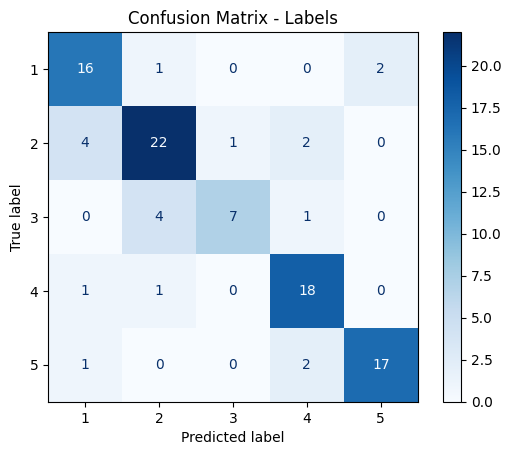

In [25]:
plt.figure(figsize=(6, 6),dpi=200)
cm_labels = confusion_matrix(true_labels, predicted_labels)
disp_labels = ConfusionMatrixDisplay(confusion_matrix=cm_labels, display_labels=[1, 2, 3, 4, 5])
disp_labels.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Labels")
# plt.savefig('/zhome/81/3/170259/SparseCBM/run_cebab/labels_confusion_matrix.png')
plt.show()

<Figure size 1200x1200 with 0 Axes>

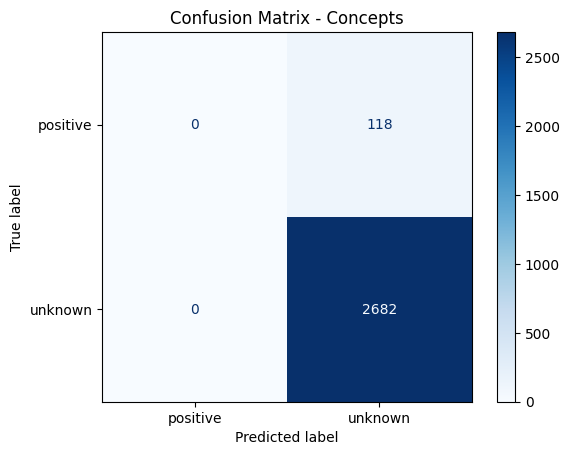

In [26]:
plt.figure(figsize=(6, 6),dpi=200)
cm_concepts = confusion_matrix(concept_true_labels, concept_predicted_labels)
disp_concepts = ConfusionMatrixDisplay(confusion_matrix=cm_concepts, display_labels=["positive", "unknown"])
disp_concepts.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Concepts")
plt.show()

## Model w. sparsity 0.3-0.5

In [27]:
# Load the model and tokenizer
model = os.path.join(model_path, "distilbert-base-uncased_mcnemar0.30.5_joint.pth")
model = torch.load(model, map_location=torch.device('cpu'))
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): SubnetLinear_Mask(
            (fc): Linear(in_features=768, out_features=768, bias=True)
            (mask_list): ParameterList(
                (0): Parameter containing: [torch.float32 of size 768x768]
                (1): Parameter containing: [torch.float32 of size 768x768]
                (2): Parameter containing: [torch.float32 of size 768x768]
                (3): Parameter containing: [torch.float32 of size 768x768]
                (4): Parameter containing: [torch.float32 of size 768x768]
                (5

In [28]:
ModelXtoCtoY_layer = torch.load(model_path+"/distilbert-base-uncased_mcnemar0.30.5_ModelXtoCtoY_layer_joint.pth",
                                map_location=torch.device('cpu')) 

In [29]:
# Initialize accumulators
test_accuracy = 0.
concept_test_accuracy = 0.
predicted_labels = np.array([])
true_labels = np.array([])
concept_predicted_labels = np.array([])
concept_true_labels = np.array([])

# Initialize a list to store activated concepts
activated_concepts_test = []

# List to store predictions for y_pred_modelA
y_pred_modelB = []

# Counter for examples displayed
examples_displayed = 0
max_examples = 5

# Evaluate the model
for epoch in range(num_epochs):
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Test", unit="batch")):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label = batch["label"].to(device)
            concept_tensors = {}
            for concept in concepts:
                concept_key = f"{concept}_concept"
                if concept_key in batch:
                    concept_tensors[concept] = batch[concept_key].to(device)  
            concept_labels = batch["concept_labels"].to(device)
            concept_labels = torch.t(concept_labels)
            concept_labels = concept_labels.contiguous().view(-1)

            XtoC_outputs = []
            XtoY_outputs = []
            for concept_idx in range(num_concept_labels):
                set_sparse_index(model, concept_idx)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                pooled_output = outputs.last_hidden_state.mean(1)

                outputs = ModelXtoCtoY_layer(pooled_output)
                XtoC_outputs.append(outputs[concept_idx + 1])
                XtoY_outputs.extend(outputs[0:1])

            # Predict labels
            predictions = torch.argmax(XtoY_outputs[0], axis=1)
            test_accuracy += torch.sum(predictions == label).item()
            predicted_labels = np.append(predicted_labels, predictions.cpu().numpy())
            true_labels = np.append(true_labels, label.cpu().numpy())
            
            # Store the predictions for this model 
            y_pred_modelB.extend(predictions.cpu().numpy())

            # Predict concepts
            XtoC_logits = torch.cat(XtoC_outputs, dim=0)
            concept_predictions = torch.argmax(XtoC_logits, axis=1)
            concept_predictions = concept_predictions.view(-1, num_concept_labels)
            concept_labels = concept_labels.view(-1, num_concept_labels)

            # Store predicted concepts for each batch
            batch_predicted_concepts = torch.argmax(torch.cat(XtoC_outputs, dim=0), dim=1)
            activated_concepts_test.extend(batch_predicted_concepts.cpu().numpy())
            batch_true_concepts = torch.argmax(concept_labels, axis=1)

            # Print some example texts with their labels and concepts
            if examples_displayed < max_examples:
                for i in range(len(label)):
                    print("Text:", tokenizer.decode(input_ids[i], skip_special_tokens=True))
                    print("True Label:", label[i].item(), "Predicted Label:", predictions[i].item())
                    true_concepts_list = [concepts[idx] for idx, val in enumerate(concept_labels[i]) if val == 1]
                    predicted_concepts_list = [concepts[idx] for idx, val in enumerate(concept_predictions[i]) if val == 1]
                    print("True Concepts:", true_concepts_list, "Predicted Concepts:", predicted_concepts_list)
                    print()
                examples_displayed += 1

            # Compute concept accuracy
            concept_test_accuracy += torch.sum(concept_predictions == concept_labels).item()
            concept_predicted_labels = np.append(concept_predicted_labels, concept_predictions.cpu().numpy().flatten())
            concept_true_labels = np.append(concept_true_labels, concept_labels.cpu().numpy().flatten())

        test_accuracy /= len(test_dataset)
        num_labels = len(np.unique(true_labels))

        concept_test_accuracy /= len(test_dataset)
        concept_num_true_labels = len(np.unique(concept_true_labels))

        macro_f1_scores = []
        for label in range(num_labels):
            label_pred = np.array(predicted_labels) == label
            label_true = np.array(true_labels) == label
            macro_f1_scores.append(f1_score(label_true, label_pred, average='macro'))
            mean_macro_f1_score = np.mean(macro_f1_scores)

        concept_macro_f1_scores = []
        for concept_label in range(concept_num_true_labels):
            concept_label_pred = np.array(concept_predicted_labels) == concept_label
            concept_label_true = np.array(concept_true_labels) == concept_label
            concept_macro_f1_scores.append(f1_score(concept_label_true, concept_label_pred, average='macro'))
            concept_mean_macro_f1_score = np.mean(concept_macro_f1_scores)

        print(f"Epoch {epoch + 1}: Test concept Acc = {concept_test_accuracy*100/num_concept_labels} Test concept Macro F1 = {concept_mean_macro_f1_score*100}")
        print(f"Epoch {epoch + 1}: Test Acc = {test_accuracy*100} Test Macro F1 = {mean_macro_f1_score*100}")

Test:   8%|▊         | 1/13 [01:25<17:08, 85.74s/batch]

Text: i bet he took down his usa flag to put this one up instead lol
True Label: 2 Predicted Label: 2
True Concepts: ['approval', 'surprise'] Predicted Concepts: []

Text: thank you for the good chuckle.
True Label: 4 Predicted Label: 4
True Concepts: ['annoyance', 'approval'] Predicted Concepts: []

Text: isn't that the point though? that's it's up to the people that aren't scientist to decide if the science has any meaning?
True Label: 1 Predicted Label: 2
True Concepts: [] Predicted Concepts: []

Text: so this is how democracy dies... with thunderous upvotes.
True Label: 0 Predicted Label: 1
True Concepts: [] Predicted Concepts: []

Text: sounds like a great chap
True Label: 4 Predicted Label: 4
True Concepts: ['disappointment'] Predicted Concepts: []

Text: the [ name ] work.
True Label: 2 Predicted Label: 2
True Concepts: [] Predicted Concepts: []

Text: you'll find a few down south, too. no surprise.
True Label: 2 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text:

Test:  15%|█▌        | 2/13 [03:54<22:31, 122.83s/batch]

Text: i ’ m pretty sure your thinking of [ name ], although i could be wrong
True Label: 2 Predicted Label: 1
True Concepts: ['approval', 'excitement', 'remorse'] Predicted Concepts: []

Text: i meant after he first suspected the incest and told [ name ]. he went to dragonstone as he was afraid he would be killed.
True Label: 1 Predicted Label: 1
True Concepts: ['desire', 'surprise'] Predicted Concepts: []

Text: well howdy neighbor. i'm also about 200m away from there. it inspired me to setup wireless security cameras.
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: hitting your kids for punishment just makes them sneakier. maybe that has something to do with the dishonesty of the church and [ religion ] in general.
True Label: 1 Predicted Label: 1
True Concepts: [] Predicted Concepts: []

Text: i agree. his own hair color is much better with his blue eyes.
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: false, if i'm c

Test:  23%|██▎       | 3/13 [06:15<21:49, 130.96s/batch]

Text: we should sign him to a 4. 5aav contract now that he has already proved himself as an elite starter in the nhl.
True Label: 3 Predicted Label: 3
True Concepts: ['pride', 'neutral'] Predicted Concepts: []

Text: congratulations! hard work always pays off! : ) hope you enjoy your new job!!
True Label: 4 Predicted Label: 4
True Concepts: ['approval', 'excitement', 'neutral'] Predicted Concepts: []

Text: and you got it, a federal tax cut. if you want to pay less taxes overall you need to stop electing democrats.
True Label: 1 Predicted Label: 1
True Concepts: ['fear', 'optimism'] Predicted Concepts: []

Text: gross. don ’ t need that diva. build it up from the trenches out.
True Label: 0 Predicted Label: 0
True Concepts: [] Predicted Concepts: []

Text: whiskey isn't going to help. she should pray to [ name ] that another man comes and brings purpose to her life.
True Label: 1 Predicted Label: 1
True Concepts: ['sadness'] Predicted Concepts: []

Text: > and no one but angry communit

Test:  31%|███       | 4/13 [08:53<21:16, 141.82s/batch]

Text: i can safely say as a " frozen pizza connoisseur " across various ovens, i've never had an unevenly cooked pizza from it being on a pan.
True Label: 3 Predicted Label: 3
True Concepts: ['embarrassment', 'realization'] Predicted Concepts: []

Text: canadian [ name ] here to disagree with you. politely. sorry.
True Label: 1 Predicted Label: 0
True Concepts: ['confusion', 'disgust'] Predicted Concepts: []

Text: the ones who agree with her are the only ones who actually address * her * issue.... which is how to deal with boundary stomping relatives.
True Label: 1 Predicted Label: 1
True Concepts: ['sadness'] Predicted Concepts: []

Text: just what i needed to hear today! thanks!
True Label: 4 Predicted Label: 4
True Concepts: [] Predicted Concepts: []

Text: with these comments i thought this was r / vegan for a sec lmao
True Label: 2 Predicted Label: 2
True Concepts: ['disgust'] Predicted Concepts: []

Text: [ name ] : " wtf, it's just a prank bro! "
True Label: 1 Predicted Label: 

Test:  38%|███▊      | 5/13 [11:23<19:18, 144.78s/batch]

Text: he sees you when you ’ re tweeting, he knows that you ’ re a fake, he knows that you love [ name ] so resign for goodness sake.
True Label: 0 Predicted Label: 0
True Concepts: ['curiosity', 'fear', 'grief'] Predicted Concepts: []

Text: yeah, but malice with the * intent * to solely intimidate op? doubtful. more like malice with the unlucky byproduct of discovery by op.
True Label: 1 Predicted Label: 1
True Concepts: ['caring', 'curiosity'] Predicted Concepts: []

Text: im putting my faith in you son
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: i believe that's the first game winner at the buzzer at home in raptors history
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: seriously?! these [ name ] have no common decency or respect for others suffering!
True Label: 0 Predicted Label: 1
True Concepts: [] Predicted Concepts: []

Text: the attraction and the action are two separate things, and you know that. no one c

Test: 100%|██████████| 13/13 [32:20<00:00, 149.29s/batch]

Epoch 1: Test concept Acc = 95.78571428571429 Test concept Macro F1 = 74.46187522801897
Epoch 1: Test Acc = 72.0 Test Macro F1 = 82.13578193931792


<Figure size 1200x1200 with 0 Axes>

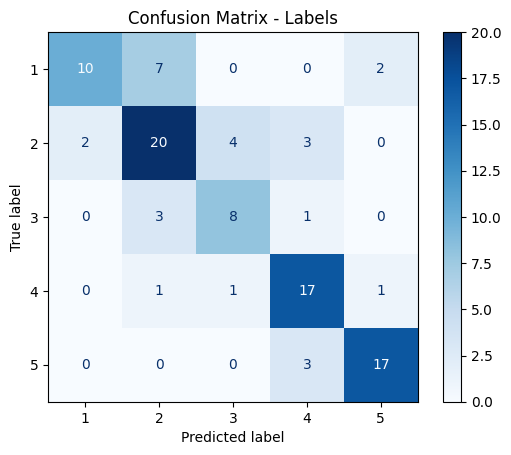

In [30]:
plt.figure(figsize=(6, 6),dpi=200)
cm_labels = confusion_matrix(true_labels, predicted_labels)
disp_labels = ConfusionMatrixDisplay(confusion_matrix=cm_labels, display_labels=[1, 2, 3, 4, 5])
disp_labels.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Labels")
# plt.savefig('/zhome/81/3/170259/SparseCBM/run_cebab/labels_confusion_matrix.png')
plt.show()

<Figure size 1200x1200 with 0 Axes>

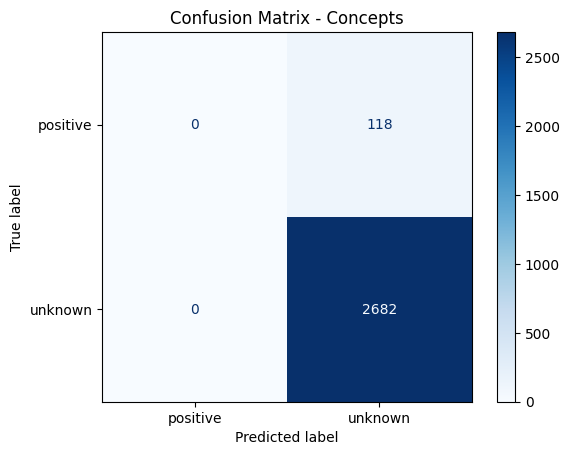

In [31]:
plt.figure(figsize=(6, 6),dpi=200)
cm_concepts = confusion_matrix(concept_true_labels, concept_predicted_labels)
disp_concepts = ConfusionMatrixDisplay(confusion_matrix=cm_concepts, display_labels=["positive", "unknown"])
disp_concepts.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Concepts")
plt.show()

## Model w. sparsity 0.7-0.9

In [34]:
# Load the model and tokenizer
model = os.path.join(model_path, "distilbert-base-uncased_mcnemar0.70.9_joint.pth")
model = torch.load(model, map_location=torch.device('cpu'))
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): SubnetLinear_Mask(
            (fc): Linear(in_features=768, out_features=768, bias=True)
            (mask_list): ParameterList(
                (0): Parameter containing: [torch.float32 of size 768x768]
                (1): Parameter containing: [torch.float32 of size 768x768]
                (2): Parameter containing: [torch.float32 of size 768x768]
                (3): Parameter containing: [torch.float32 of size 768x768]
                (4): Parameter containing: [torch.float32 of size 768x768]
                (5

In [35]:
ModelXtoCtoY_layer = torch.load(model_path+"/distilbert-base-uncased_mcnemar0.70.9_ModelXtoCtoY_layer_joint.pth",
                                map_location=torch.device('cpu')) 

In [36]:
# Initialize accumulators
test_accuracy = 0.
concept_test_accuracy = 0.
predicted_labels = np.array([])
true_labels = np.array([])
concept_predicted_labels = np.array([])
concept_true_labels = np.array([])

# Initialize a list to store activated concepts
activated_concepts_test = []

# List to store predictions for y_pred_modelA
y_pred_modelC = []

# Counter for examples displayed
examples_displayed = 0
max_examples = 5

# Evaluate the model
for epoch in range(num_epochs):
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Test", unit="batch")):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label = batch["label"].to(device)
            concept_tensors = {}
            for concept in concepts:
                concept_key = f"{concept}_concept"
                if concept_key in batch:
                    concept_tensors[concept] = batch[concept_key].to(device)  
            concept_labels = batch["concept_labels"].to(device)
            concept_labels = torch.t(concept_labels)
            concept_labels = concept_labels.contiguous().view(-1)

            XtoC_outputs = []
            XtoY_outputs = []
            for concept_idx in range(num_concept_labels):
                set_sparse_index(model, concept_idx)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                pooled_output = outputs.last_hidden_state.mean(1)

                outputs = ModelXtoCtoY_layer(pooled_output)
                XtoC_outputs.append(outputs[concept_idx + 1])
                XtoY_outputs.extend(outputs[0:1])

            # Predict labels
            predictions = torch.argmax(XtoY_outputs[0], axis=1)
            test_accuracy += torch.sum(predictions == label).item()
            predicted_labels = np.append(predicted_labels, predictions.cpu().numpy())
            true_labels = np.append(true_labels, label.cpu().numpy())
            
            # Store the predictions for this model 
            y_pred_modelC.extend(predictions.cpu().numpy())

            # Predict concepts
            XtoC_logits = torch.cat(XtoC_outputs, dim=0)
            concept_predictions = torch.argmax(XtoC_logits, axis=1)
            concept_predictions = concept_predictions.view(-1, num_concept_labels)
            concept_labels = concept_labels.view(-1, num_concept_labels)

            # Store predicted concepts for each batch
            batch_predicted_concepts = torch.argmax(torch.cat(XtoC_outputs, dim=0), dim=1)
            activated_concepts_test.extend(batch_predicted_concepts.cpu().numpy())
            batch_true_concepts = torch.argmax(concept_labels, axis=1)

            # Print some example texts with their labels and concepts
            if examples_displayed < max_examples:
                for i in range(len(label)):
                    print("Text:", tokenizer.decode(input_ids[i], skip_special_tokens=True))
                    print("True Label:", label[i].item(), "Predicted Label:", predictions[i].item())
                    true_concepts_list = [concepts[idx] for idx, val in enumerate(concept_labels[i]) if val == 1]
                    predicted_concepts_list = [concepts[idx] for idx, val in enumerate(concept_predictions[i]) if val == 1]
                    print("True Concepts:", true_concepts_list, "Predicted Concepts:", predicted_concepts_list)
                    print()
                examples_displayed += 1

            # Compute concept accuracy
            concept_test_accuracy += torch.sum(concept_predictions == concept_labels).item()
            concept_predicted_labels = np.append(concept_predicted_labels, concept_predictions.cpu().numpy().flatten())
            concept_true_labels = np.append(concept_true_labels, concept_labels.cpu().numpy().flatten())

        test_accuracy /= len(test_dataset)
        num_labels = len(np.unique(true_labels))

        concept_test_accuracy /= len(test_dataset)
        concept_num_true_labels = len(np.unique(concept_true_labels))

        macro_f1_scores = []
        for label in range(num_labels):
            label_pred = np.array(predicted_labels) == label
            label_true = np.array(true_labels) == label
            macro_f1_scores.append(f1_score(label_true, label_pred, average='macro'))
            mean_macro_f1_score = np.mean(macro_f1_scores)

        concept_macro_f1_scores = []
        for concept_label in range(concept_num_true_labels):
            concept_label_pred = np.array(concept_predicted_labels) == concept_label
            concept_label_true = np.array(concept_true_labels) == concept_label
            concept_macro_f1_scores.append(f1_score(concept_label_true, concept_label_pred, average='macro'))
            concept_mean_macro_f1_score = np.mean(concept_macro_f1_scores)

        print(f"Epoch {epoch + 1}: Test concept Acc = {concept_test_accuracy*100/num_concept_labels} Test concept Macro F1 = {concept_mean_macro_f1_score*100}")
        print(f"Epoch {epoch + 1}: Test Acc = {test_accuracy*100} Test Macro F1 = {mean_macro_f1_score*100}")

Test:   8%|▊         | 1/13 [01:18<15:47, 78.99s/batch]

Text: i bet he took down his usa flag to put this one up instead lol
True Label: 2 Predicted Label: 3
True Concepts: ['approval', 'surprise'] Predicted Concepts: []

Text: thank you for the good chuckle.
True Label: 4 Predicted Label: 4
True Concepts: ['annoyance', 'approval'] Predicted Concepts: []

Text: isn't that the point though? that's it's up to the people that aren't scientist to decide if the science has any meaning?
True Label: 1 Predicted Label: 2
True Concepts: [] Predicted Concepts: []

Text: so this is how democracy dies... with thunderous upvotes.
True Label: 0 Predicted Label: 0
True Concepts: [] Predicted Concepts: []

Text: sounds like a great chap
True Label: 4 Predicted Label: 4
True Concepts: ['disappointment'] Predicted Concepts: []

Text: the [ name ] work.
True Label: 2 Predicted Label: 2
True Concepts: [] Predicted Concepts: []

Text: you'll find a few down south, too. no surprise.
True Label: 2 Predicted Label: 1
True Concepts: [] Predicted Concepts: []

Text:

Test:  15%|█▌        | 2/13 [03:12<18:12, 99.33s/batch]

Text: i ’ m pretty sure your thinking of [ name ], although i could be wrong
True Label: 2 Predicted Label: 1
True Concepts: ['approval', 'excitement', 'remorse'] Predicted Concepts: []

Text: i meant after he first suspected the incest and told [ name ]. he went to dragonstone as he was afraid he would be killed.
True Label: 1 Predicted Label: 1
True Concepts: ['desire', 'surprise'] Predicted Concepts: []

Text: well howdy neighbor. i'm also about 200m away from there. it inspired me to setup wireless security cameras.
True Label: 3 Predicted Label: 2
True Concepts: [] Predicted Concepts: []

Text: hitting your kids for punishment just makes them sneakier. maybe that has something to do with the dishonesty of the church and [ religion ] in general.
True Label: 1 Predicted Label: 1
True Concepts: [] Predicted Concepts: []

Text: i agree. his own hair color is much better with his blue eyes.
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: false, if i'm c

Test:  23%|██▎       | 3/13 [05:45<20:38, 123.85s/batch]

Text: we should sign him to a 4. 5aav contract now that he has already proved himself as an elite starter in the nhl.
True Label: 3 Predicted Label: 2
True Concepts: ['pride', 'neutral'] Predicted Concepts: []

Text: congratulations! hard work always pays off! : ) hope you enjoy your new job!!
True Label: 4 Predicted Label: 4
True Concepts: ['approval', 'excitement', 'neutral'] Predicted Concepts: []

Text: and you got it, a federal tax cut. if you want to pay less taxes overall you need to stop electing democrats.
True Label: 1 Predicted Label: 1
True Concepts: ['fear', 'optimism'] Predicted Concepts: []

Text: gross. don ’ t need that diva. build it up from the trenches out.
True Label: 0 Predicted Label: 0
True Concepts: [] Predicted Concepts: []

Text: whiskey isn't going to help. she should pray to [ name ] that another man comes and brings purpose to her life.
True Label: 1 Predicted Label: 1
True Concepts: ['sadness'] Predicted Concepts: []

Text: > and no one but angry communit

Test:  31%|███       | 4/13 [08:11<19:51, 132.41s/batch]

Text: i can safely say as a " frozen pizza connoisseur " across various ovens, i've never had an unevenly cooked pizza from it being on a pan.
True Label: 3 Predicted Label: 3
True Concepts: ['embarrassment', 'realization'] Predicted Concepts: []

Text: canadian [ name ] here to disagree with you. politely. sorry.
True Label: 1 Predicted Label: 0
True Concepts: ['confusion', 'disgust'] Predicted Concepts: []

Text: the ones who agree with her are the only ones who actually address * her * issue.... which is how to deal with boundary stomping relatives.
True Label: 1 Predicted Label: 1
True Concepts: ['sadness'] Predicted Concepts: []

Text: just what i needed to hear today! thanks!
True Label: 4 Predicted Label: 4
True Concepts: [] Predicted Concepts: []

Text: with these comments i thought this was r / vegan for a sec lmao
True Label: 2 Predicted Label: 2
True Concepts: ['disgust'] Predicted Concepts: []

Text: [ name ] : " wtf, it's just a prank bro! "
True Label: 1 Predicted Label: 

Test:  38%|███▊      | 5/13 [10:43<18:36, 139.53s/batch]

Text: he sees you when you ’ re tweeting, he knows that you ’ re a fake, he knows that you love [ name ] so resign for goodness sake.
True Label: 0 Predicted Label: 0
True Concepts: ['curiosity', 'fear', 'grief'] Predicted Concepts: []

Text: yeah, but malice with the * intent * to solely intimidate op? doubtful. more like malice with the unlucky byproduct of discovery by op.
True Label: 1 Predicted Label: 1
True Concepts: ['caring', 'curiosity'] Predicted Concepts: []

Text: im putting my faith in you son
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: i believe that's the first game winner at the buzzer at home in raptors history
True Label: 3 Predicted Label: 3
True Concepts: [] Predicted Concepts: []

Text: seriously?! these [ name ] have no common decency or respect for others suffering!
True Label: 0 Predicted Label: 1
True Concepts: [] Predicted Concepts: []

Text: the attraction and the action are two separate things, and you know that. no one c

Test: 100%|██████████| 13/13 [29:22<00:00, 135.58s/batch]

Epoch 1: Test concept Acc = 95.78571428571429 Test concept Macro F1 = 74.46187522801897
Epoch 1: Test Acc = 69.0 Test Macro F1 = 80.2016893836948


<Figure size 1200x1200 with 0 Axes>

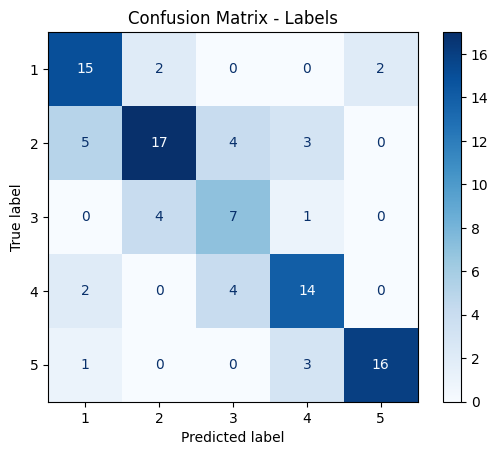

In [38]:
plt.figure(figsize=(6, 6),dpi=200)
cm_labels = confusion_matrix(true_labels, predicted_labels)
disp_labels = ConfusionMatrixDisplay(confusion_matrix=cm_labels, display_labels=[1, 2, 3, 4, 5])
disp_labels.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Labels")
# plt.savefig('/zhome/81/3/170259/SparseCBM/run_cebab/labels_confusion_matrix.png')
plt.show()

<Figure size 1200x1200 with 0 Axes>

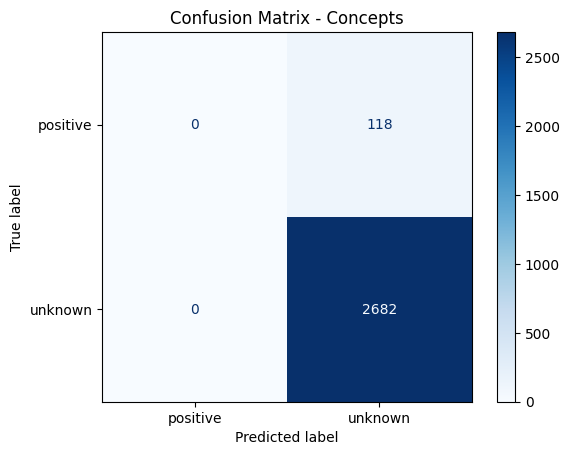

In [39]:
plt.figure(figsize=(6, 6),dpi=200)
cm_concepts = confusion_matrix(concept_true_labels, concept_predicted_labels)
disp_concepts = ConfusionMatrixDisplay(confusion_matrix=cm_concepts, display_labels=["positive", "unknown"])
disp_concepts.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Concepts")
plt.show()

## The McNemar's test

In [42]:
y_true = true_labels

# Initialize contingency table counts
a = b = c = d = 0

# Fill the contingency table
for true, pred_a, pred_b in zip(y_true, y_pred_modelA, y_pred_modelB):
    if pred_a == true and pred_b == true:
        a += 1
    elif pred_a == true and pred_b != true:
        b += 1
    elif pred_a != true and pred_b == true:
        c += 1
    elif pred_a != true and pred_b != true:
        d += 1

# Create contingency table
table = [[a, b], [c, d]]

# Perform McNemar test
result = mcnemar(table, exact=False, correction=True)

print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

statistic=2.450, p-value=0.118


In [43]:
# Initialize contingency table counts
a = b = c = d = 0

# Fill the contingency table
for true, pred_a, pred_b in zip(y_true, y_pred_modelA, y_pred_modelC):
    if pred_a == true and pred_b == true:
        a += 1
    elif pred_a == true and pred_b != true:
        b += 1
    elif pred_a != true and pred_b == true:
        c += 1
    elif pred_a != true and pred_b != true:
        d += 1

# Create contingency table
table = [[a, b], [c, d]]

# Perform McNemar test
result = mcnemar(table, exact=False, correction=True)

print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

statistic=5.882, p-value=0.015
